In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats


In [13]:
############### Synthetic Data #############
β = 0.005
μ1 = 1/21 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ω=1/9 # 9 days until emitted to hospital
ϵ = 0.0001
pp = 0.7
capT = 10000
γ = 1/(80*365)
Input_H = [1500,1,0,0,0]

Input_H = [1500, 1, 0 ,0, 0]
parameters = [Input_H, μ1, μ2, σ, ω,  capT] 

In [6]:
def gillespieSEIHR(initial, beta, mu1,mu2, sigma, omega, alpha, epsilon, mort,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time and (pop[ind][1]+pop[ind][2]+pop[ind][3]>0):
        state = np.zeros(shape= (5,12))
        
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2] + alpha*pop[ind][3])/N + epsilon*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0,0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0,0]
        
        R_ih = omega*pop[ind][2]
        state[:,2] = [0, 0, -1, 1, 0]
        
        R_ir = mort*mu1*pop[ind][2]
        state[:,3] = [0,0,-1,0,1]
        
        R_hr = mort*mu2*pop[ind][3]
        state[:,4] = [0,0,0,-1,1]

        R_is = (1-mort)*mu1*pop[ind][2]
        state[:,5] = [1,0,-1,0,0]

        R_hs = (1-mort)*mu2*pop[ind][3]
        state[:,6] = [1,0,0,-1,0]
        
        rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs]

        Rtotal = sum(rate)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        
#         total_inf = sum(cuminf)
        if event == 1:
            cuminf.append(1 + cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:5])
    return event_time, np.array(pop), events, cuminf

In [34]:
M =gillespieSEIHR(parameters[0], β, parameters[1],parameters[2],
                      parameters[3], parameters[4], α,ϵ,pp,  parameters[5])
time = [] #make results of M a step function
cuminf = [] #steps
for ind, x in enumerate(M[0]):
    if ind < len(M[0])-1:
        time.append((M[0][ind], M[0][ind+1]))
        cuminf.append((M[3][ind], M[3][ind]))
time = np.array(time).flatten()
cuminf = np.array(cuminf).flatten()
max_inf = max(cuminf)
max_time = math.ceil(max(time))


intert = np.arange(0, max_time +1 , 1) #interpolate to daily steps
intercum = np.interp(intert, time,cuminf) #daily steps


In [43]:
intert = np.array(intert, dtype = int)
intert

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

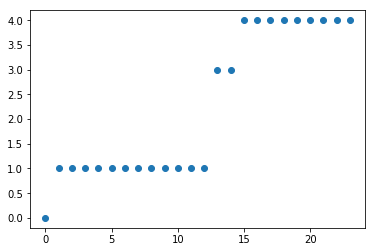

In [53]:
plt.plot(intert, intercum, 'o') # This is the synthetic data
summary = np.array([[int(a) for a in intert], [int(b) for b in intercum]])

# Perform ABC on the synthetic data

In [56]:
N = 50
tol = 91
t = 0 
θ = []
β1, ɛ1, α1,p1 =  [np.random.uniform(0,0.1, N), np.random.uniform(0,0.001, N),np.random.uniform(0,1, N), np.random.uniform(0,1, N)]
#     print(np.array([β1, ɛ1, p1 ]))
θ = [np.array([β1, ɛ1, α1, p1]).T]
# print(θ[0][:,0])
t = 1
θ_t = []
tols = []
tols.append(tol)
error = []
while t< 6:
    r_β = np.random.randint(0, N-1)
    r_ϵ = np.random.randint(0,N-1)
    r_α = np.random.randint(0,N-1)
    r_p = np.random.randint(0,N-1)
    δ = np.random.uniform(0, 1e-3)
    βt, ɛt,αt, pt = θ[t-1][:,0][r_β] +δ, θ[t-1][:,1][r_ϵ] +δ,θ[t-1][:,2][r_α] + δ, θ[t-1][:,3][r_p] +δ

    M =gillespieSEIHR(parameters[0], βt, parameters[1],parameters[2],
                      parameters[3], parameters[4], αt,ɛt,pt,  parameters[5])
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(M[0]):
        if ind < len(M[0])-1:
            time.append((M[0][ind], M[0][ind+1]))
            cuminf.append((M[3][ind], M[3][ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
#     print(max_inf, max_time, βt, ɛt)
    

    summary_time = summary[0]
#         print(summary_time, max(summary_time[0]), max_time)
    summary_cum = summary[1]
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 1)
        summary_time = np.append(summary_time, length1)
#         print(summary_time, len( length1))
        summary_cum = np.append(summary_cum, max(summary[1])*np.ones(len(length1 )))
#         print(summary_cum)
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 1)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))
        
    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) #daily steps
    
#         print(summary_time, summary_cum)
#     print(np.linalg.norm(summary_cum-inter_cum[summary_time]), βt, ɛt, pt)
    if np.linalg.norm(summary_cum-inter_cum[summary_time]) <tol:
        θ_t.append(np.array([βt, ɛt, αt, pt]))
        print(len(θ_t), t, tol, np.linalg.norm(summary_cum-inter_cum[summary_time]))
#             θ_t = np.array(θ_t)
#             print(θ_t)
        error.append(np.linalg.norm(summary_cum-inter_cum[summary_time]))
    if len(θ_t) == N:
        tol = np.median(error)
        tols.append(tol)
        θ_t = np.array(θ_t)
        print(θ_t)
        θ.append(θ_t)
        t +=1 
        θ_t = []
        error = []

1 1 91 85.45759182190895
2 1 91 9.486832980505138
3 1 91 9.746794344808963
4 1 91 9.486832980505138
5 1 91 9.486832980505138
6 1 91 9.591663046625438
7 1 91 9.433981132056603
8 1 91 10.488088481701515
9 1 91 28.809720581775867
10 1 91 9.539392014169456
11 1 91 57.201398584300364
12 1 91 9.539392014169456
13 1 91 9.433981132056603
14 1 91 9.797958971132712
15 1 91 9.433981132056603
16 1 91 71.33722730804723
17 1 91 9.433981132056603
18 1 91 9.433981132056603
19 1 91 9.433981132056603
20 1 91 9.433981132056603
21 1 91 6.928203230275509
22 1 91 9.486832980505138
23 1 91 9.433981132056603
24 1 91 9.433981132056603
25 1 91 7.0
26 1 91 35.4400902933387
27 1 91 21.97726097583591
28 1 91 9.433981132056603
29 1 91 6.244997998398398
30 1 91 6.6332495807108
31 1 91 9.486832980505138
32 1 91 9.486832980505138
33 1 91 9.539392014169456
34 1 91 90.42123644365851
35 1 91 22.47220505424423
36 1 91 9.539392014169456
37 1 91 9.433981132056603
38 1 91 5.656854249492381
39 1 91 7.0710678118654755
40 1 91 

1 3 9.433981132056603 6.928203230275509
2 3 9.433981132056603 6.928203230275509
3 3 9.433981132056603 4.795831523312719
4 3 9.433981132056603 7.0
5 3 9.433981132056603 7.0
6 3 9.433981132056603 6.782329983125268
7 3 9.433981132056603 7.54983443527075
8 3 9.433981132056603 6.928203230275509
9 3 9.433981132056603 7.54983443527075
10 3 9.433981132056603 6.928203230275509
11 3 9.433981132056603 6.855654600401044
12 3 9.433981132056603 4.58257569495584
13 3 9.433981132056603 6.708203932499369
14 3 9.433981132056603 6.782329983125268
15 3 9.433981132056603 7.0
16 3 9.433981132056603 6.6332495807108
17 3 9.433981132056603 9.0
18 3 9.433981132056603 6.928203230275509
19 3 9.433981132056603 7.0
20 3 9.433981132056603 7.0710678118654755
21 3 9.433981132056603 5.916079783099616
22 3 9.433981132056603 7.280109889280518
23 3 9.433981132056603 6.557438524302
24 3 9.433981132056603 5.196152422706632
25 3 9.433981132056603 5.0
26 3 9.433981132056603 7.0710678118654755
27 3 9.433981132056603 6.85565460

1 5 6.284776659367578 3.4641016151377544
2 5 6.284776659367578 3.872983346207417
3 5 6.284776659367578 5.5677643628300215
4 5 6.284776659367578 4.47213595499958
5 5 6.284776659367578 6.244997998398398
6 5 6.284776659367578 3.4641016151377544
7 5 6.284776659367578 3.872983346207417
8 5 6.284776659367578 4.358898943540674
9 5 6.284776659367578 6.164414002968976
10 5 6.284776659367578 6.082762530298219
11 5 6.284776659367578 3.7416573867739413
12 5 6.284776659367578 4.69041575982343
13 5 6.284776659367578 6.0
14 5 6.284776659367578 5.291502622129181
15 5 6.284776659367578 5.291502622129181
16 5 6.284776659367578 3.4641016151377544
17 5 6.284776659367578 5.656854249492381
18 5 6.284776659367578 4.795831523312719
19 5 6.284776659367578 5.477225575051661
20 5 6.284776659367578 5.916079783099616
21 5 6.284776659367578 5.291502622129181
22 5 6.284776659367578 5.744562646538029
23 5 6.284776659367578 4.0
24 5 6.284776659367578 4.898979485566356
25 5 6.284776659367578 5.0
26 5 6.284776659367578 

In [41]:
len(summary_cum)
len(inter_cum)
summary_time

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.765e+03, 1.766e+03,
       1.767e+03])

In [62]:
α

0.5

In [58]:
np.save('theta_synthetic', θ)
np.save('tols_synthetic', tols)

/home/emma/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


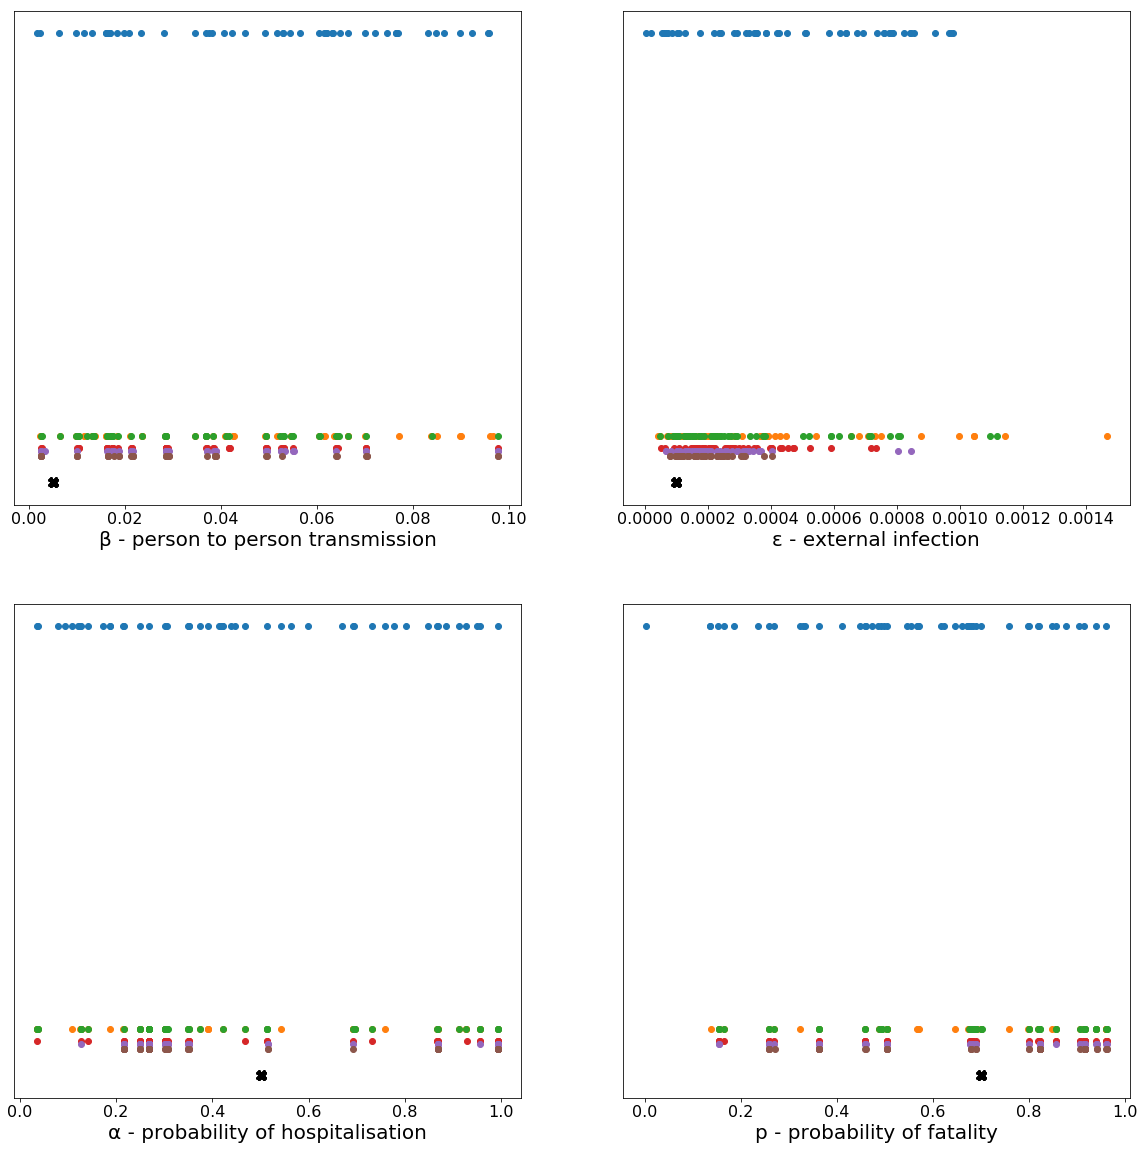

In [67]:
plt.figure(figsize = (20,20))
tol = 6
for i in range(6):
    plt.subplot(2,2,1)
    plt.plot(θ[i][:,0], tols[i]*np.ones(50), 'o' )
    plt.plot(β, 0, 'X',markersize = 10, color = 'k')
    plt.xlabel('β - person to person transmission', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)
    
    plt.subplot(2,2,2)
    plt.plot(θ[i][:,1], tols[i]*np.ones(50), 'o' )
    plt.xlabel('ɛ - external infection', fontsize = 20)
    plt.plot(ϵ, 0, 'X',markersize = 10, color = 'k')
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(2,2,3)
    plt.plot(θ[i][:,2], tols[i]*np.ones(50), 'o' )
    plt.xlabel('α - probability of hospitalisation', fontsize = 20)
    plt.plot(α, 0, 'X',markersize = 10, color = 'k')
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(2,2,4)
    plt.plot(θ[i][:,3], tols[i]*np.ones(50), 'o' )
    plt.plot(pp, 0, 'X',markersize = 10, color = 'k')
    plt.xlabel('p - probability of fatality', fontsize = 20)
    plt.yticks([])        
    plt.xticks(fontsize = 16)

/home/emma/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4]),
 <a list of 11 Text xticklabel objects>)

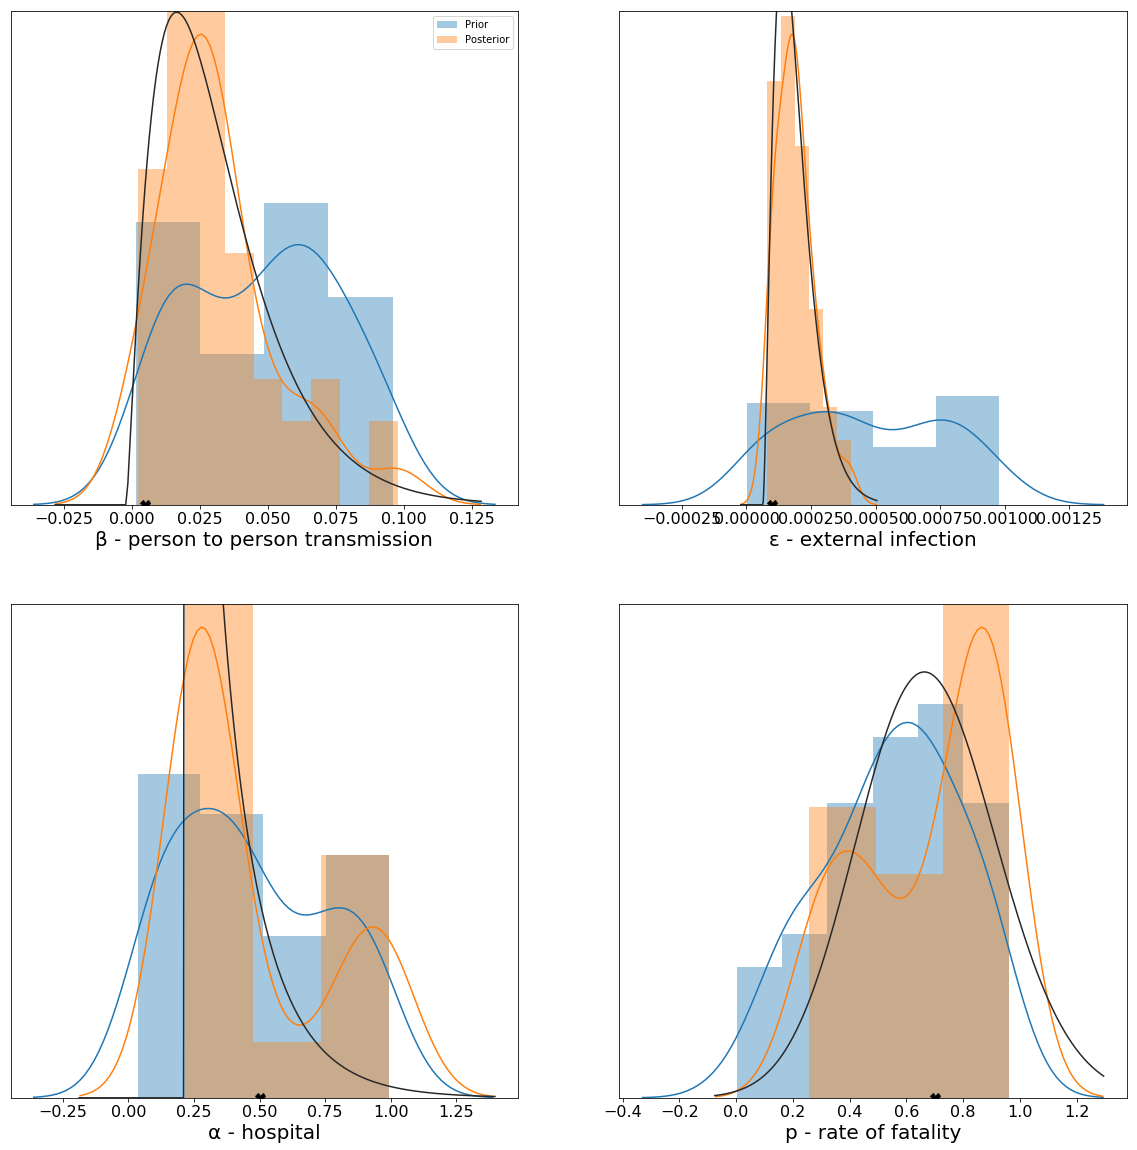

In [79]:
plt.figure(figsize = (20,20))

plt.subplot(2,2,1)
#     plt.plot(θ[i][:,0], tols[i]*np.ones(50), 'o' )
sns.distplot(θ[0][:,0],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,0],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.plot(β, 0, 'X',markersize = 10, color = 'k')

plt.xlabel('β - person to person transmission', fontsize = 20)
plt.yticks([])
plt.legend()
plt.xticks(fontsize = 16)

plt.subplot(2,2,2)
#     plt.plot(θ[i][:,1], tols[i]*np.ones(50), 'o' )
sns.distplot(θ[0][:,1],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,1],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.plot(ϵ, 0, 'X',markersize = 10, color = 'k')

plt.xlabel('ɛ - external infection', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(2,2,3)
#     plt.plot([1/a for a in θ[i][:,2]], tols[i]*np.ones(50), 'o' )
sns.distplot([a for a in θ[0][:,2]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([a for a in θ[5][:,2]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.plot(α, 0, 'X',markersize = 10, color = 'k')

plt.xlabel('α - hospital', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(2,2,4)
sns.distplot([a for a in θ[0][:,3]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([a for a in θ[5][:,3]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
# plt.plot([1/b for b in θ[i][:,3]] , tols[i]*np.ones(50), 'o' )
plt.plot(pp, 0, 'X',markersize = 10, color = 'k')

# plt.xlim([0,1])
plt.xlabel('p - rate of fatality', fontsize = 20)
plt.yticks([])        
plt.xticks(fontsize = 16)
